In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook


In [2]:
# reading data with images description

data_df = pd.read_csv('./data/NAPS_valence_arousal_2014.csv', sep=';')
data_df.head()

,ID,Category,Nr,V_H,Description,Valence,Arousal
0,Animals_001_h,Animals,1,h,Dead Stork,"2,57","6,44"
1,Animals_002_v,Animals,2,v,Lion,"6,24","6,68"
2,Animals_003_h,Animals,3,h,Snake,"5,24","5,52"
3,Animals_004_v,Animals,4,v,Wolf,"4,50","7,02"
4,Animals_005_h,Animals,5,h,Bat,"5,31","5,82"


In [3]:
# casting Valence and Arousal to float values

data_df['Valence_float'] = data_df['Valence'].map(lambda x: float(x.replace(',','.')))
data_df['Arousal_float'] = data_df['Arousal'].map(lambda x: float(x.replace(',','.')))

data_df.describe()

,Nr,Valence_float,Arousal_float
count,1356.000000,1356.000000,1356.000000
mean,144.870944,5.391947,5.101881
std,92.428420,1.628732,1.058333
min,1.000000,1.330000,2.040000
25%,68.000000,4.060000,4.430000
50%,136.000000,5.660000,4.980000
75%,208.250000,6.772500,5.820000
max,372.000000,8.540000,8.050000


In [83]:
# dividing Arousal and Valence into classes (low/medium/high)
# using percentiles, so that amount of images with low valence == amount of images with medium valence == amount of images with high valence...

def mapping(x, labels, series, percentile_width):
        for i in range(len(labels)):
            if x <= series.quantile((i + 1) * percentile_width):
                return labels[i]

def divide_into(labels, series):
    range = series.max() - series.min()
    percentile_width = 1 / len(labels)
    
    return series.map(lambda x: mapping(x, labels, series, percentile_width))

data_df['Valence_class'] = divide_into(['low', 'medium', 'high'], data_df['Valence_float'])
data_df['Arousal_class'] = divide_into(['low', 'medium', 'high'], data_df['Arousal_float'])
data_df = data_df.filter(['ID', 'Valence_float', 'Arousal_float', 'Valence_class', 'Arousal_class'])

data_df.head(10)

,ID,Valence_float,Arousal_float,Valence_class,Arousal_class
0,Animals_001_h,2.57,6.44,low,high
1,Animals_002_v,6.24,6.68,medium,high
2,Animals_003_h,5.24,5.52,medium,medium
3,Animals_004_v,4.50,7.02,low,high
4,Animals_005_h,5.31,5.82,medium,high
5,Animals_006_v,5.13,6.23,medium,high
6,Animals_007_h,4.76,7.06,medium,high
7,Animals_008_v,2.63,6.80,low,high
8,Animals_009_v,5.79,5.61,medium,high
9,Animals_010_h,4.59,5.90,low,high


In [91]:
# extracting image ID and Valence/Arousal classes from dataframe

classification_data = data_df
classification_data['Class'] = pd.Series()
classification_data.head()

def join_classes(row):
    row['Class'] = 'Valence: ' + row['Valence_class'] + ', Arousal: ' + row['Arousal_class']
    return row

classification_data = classification_data.apply(lambda x: join_classes(x), axis=1)

classification_data['Class'].value_counts()

Valence: low, Arousal: high         360
Valence: high, Arousal: low         307
Valence: medium, Arousal: medium    234
Valence: medium, Arousal: low       153
Valence: high, Arousal: medium      128
Valence: low, Arousal: medium        89
Valence: medium, Arousal: high       63
Valence: high, Arousal: high         19
Valence: low, Arousal: low            3
Name: Class, dtype: int64

In [92]:
# as we see above, vast amount of images has low/high, high/low or medium/medium class
classification_data.head()

,ID,Valence_float,Arousal_float,Valence_class,Arousal_class,Class
0,Animals_001_h,2.57,6.44,low,high,"Valence: low, Arousal: high"
1,Animals_002_v,6.24,6.68,medium,high,"Valence: medium, Arousal: high"
2,Animals_003_h,5.24,5.52,medium,medium,"Valence: medium, Arousal: medium"
3,Animals_004_v,4.50,7.02,low,high,"Valence: low, Arousal: high"
4,Animals_005_h,5.31,5.82,medium,high,"Valence: medium, Arousal: high"


In [93]:
# let's import some data from sensors

from os import listdir
import time
import datetime
import re
data_base_dir = './data/2018-afcai-spring/'

def read_filenames_regex(regex, dir):
    return list(filter(lambda filename: re.match(regex, filename), listdir(dir)))

    
def read_showed_images_file(dir_name):
    dir = data_base_dir + dir_name + '/'
    ts_filename = read_filenames_regex('.*timestamp.csv', dir)
    all_ts_file = pd.read_csv(dir + ts_filename[0], names=['filename', 'datetime'])
    without_trail = all_ts_file.loc[all_ts_file.iloc[:,0].str.contains(r'^((?!trail).)*$')]
    without_trail['image_id'] = without_trail['filename'].map(lambda x: re.search('[a-zA-Z]*_[0-9]*_[a-z]', x).group(0))
    without_trail['timestamp'] = without_trail['datetime'].map(lambda dt: int(datetime.datetime.strptime(dt, "%Y-%m-%d %H:%M:%S.%f").timestamp()*1000))
    images_df = without_trail.filter(['image_id', 'timestamp'])
    images_df['timestamp'] = images_df['timestamp'].map(lambda x: int(x/1000))
    images_df.set_index('timestamp', inplace=True)
    return fill_ts_indexes(images_df).sort_index()


def fill_ts_indexes(df):
    for i in range(min(df.index), max(df.index) + 10):
        if i in df.index:
            x = df.loc[i, 'image_id']
        else:
            df.loc[i] = [x]
    return df.sort_index()    

In [94]:
def read_bitalino_bpm(dir_name):
    dir = data_base_dir + dir_name + '/BITalino/'
    bpm_file = dir + read_filenames_regex('.*BPM.*', dir)[0]
    return pd.read_csv(bpm_file)

def read_bitalino_gsr(dir_name):
    dir = data_base_dir + dir_name + '/BITalino/'
    bpm_file = dir + read_filenames_regex('.*GSR.*', dir)[0]
    return pd.read_csv(bpm_file)

def read_person_data_from(dir_name, process_function):
    if dir_name[0] == 'B':
        gsr = process_function(read_bitalino_gsr(dir_name))
        bpm = process_function(read_bitalino_bpm(dir_name))
    showed_images = read_showed_images_file(dir_name)
    bpm = bpm.rename(columns={'value':'bpm'})
    gsr = gsr.rename(columns={'value':'gsr'})
    person_data = {'images': showed_images, 'bpm': bpm, 'gsr': gsr}
    person_data = drop_redundat_measurements(person_data)
    person_data = person_data['bpm'].join(person_data['gsr']).join(person_data['images'])
    return person_data.join(classification_data.set_index('ID'), on='image_id')

    
def drop_redundat_measurements(person_data):
    person_data['bpm'].drop([ts for ts in person_data['bpm'].index.tolist() if ts not in person_data['images'].index.tolist()], inplace=True)
    person_data['gsr'].drop([ts for ts in person_data['gsr'].index.tolist() if ts not in person_data['images'].index.tolist()], inplace=True)
    return person_data

    
def mean_for(millis, ts_val_df):
    ts_val_df['timestamp'] = ts_val_df['timestamp'].map(lambda x: int(x/1000))
    ts_val_df = ts_val_df.groupby(['timestamp']).mean()
    ts_val_df['value'] = ts_val_df[' value'].map(lambda x: int(x))
    return ts_val_df.filter(['value'])
    
def one_sec_mean(ts_val_df):
    return mean_for(1000, ts_val_df)

def half_sec_mean(ts_val_df):
    return mean_for(500, ts_val_df)

identity = lambda x: x
    

# that's example import for one person ('B365'). Measurements from sensors are rounded to one second
person_data = read_person_data_from('B365', one_sec_mean)

person_data.head(20)

C:\Users\mateu\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:17: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\Users\mateu\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\mateu\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,bpm,gsr,image_id,Valence_float,Arousal_float,Valence_class,Arousal_class,Class
timestamp,,,,,,,,
1521554075,520,873,Faces_134_h,7.43,5.68,high,high,"Valence: high, Arousal: high"
1521554076,497,867,Faces_134_h,7.43,5.68,high,high,"Valence: high, Arousal: high"
1521554077,497,866,Faces_134_h,7.43,5.68,high,high,"Valence: high, Arousal: high"
1521554078,530,893,Faces_134_h,7.43,5.68,high,high,"Valence: high, Arousal: high"
1521554079,496,906,Faces_134_h,7.43,5.68,high,high,"Valence: high, Arousal: high"
1521554080,510,892,Faces_134_h,7.43,5.68,high,high,"Valence: high, Arousal: high"
1521554081,501,880,Faces_134_h,7.43,5.68,high,high,"Valence: high, Arousal: high"
1521554082,516,876,Faces_134_h,7.43,5.68,high,high,"Valence: high, Arousal: high"
1521554083,498,874,Faces_134_h,7.43,5.68,high,high,"Valence: high, Arousal: high"


In [95]:
# Now let's look which images given person were watching

person_data['Class'].value_counts()

# As we see, there are mainly low/high and high/low images

Valence: low, Arousal: high         120
Valence: high, Arousal: low         110
Valence: medium, Arousal: high       77
Valence: high, Arousal: high         63
Valence: low, Arousal: medium        33
Valence: medium, Arousal: low        11
Valence: medium, Arousal: medium     11
Name: Class, dtype: int64

<IPython.core.display.Javascript object>


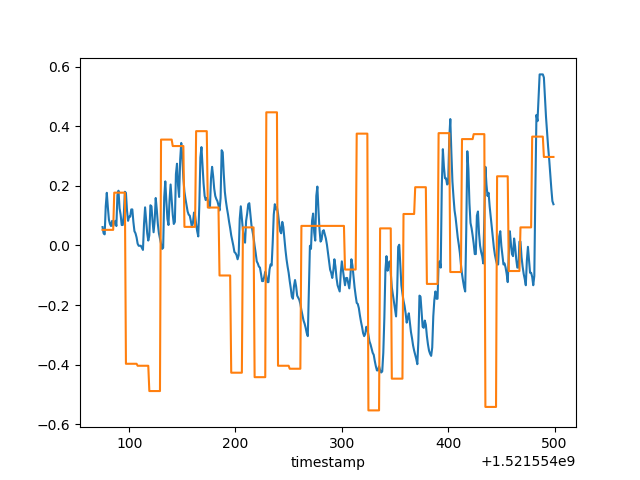

In [495]:
# now I visualize session of this person

def normalize(df):
    return (df - df.mean()) / (df.max() - df.min())

normalize(person_data['gsr']).plot()
normalize(person_data['Arousal_float']).plot()

# visualisation of example data (Arousal level (float) and GSR, both normalized)

In [824]:
# let's try to do some machine learning using data from one session
# firstly we will extract features (measurements) and labels (Arousal and Valence classes)

def norm(arr):
    div = (max(arr) - min(arr))
    if div == 0:
        div = 1
    return [(i - min(arr))/div for i in arr]

def extract_features(person_data):

    # frame is the time when a person is looking at one image (~10 seconds)
    def process_frame(frame):
        vec = frame['bpm'].tolist()[:10] + frame['gsr'].tolist()[:10]
        return vec


    learning_df = person_data.filter(['image_id', 'bpm', 'gsr', 'Class'])
    
    learning_df.fillna(value='unknown', inplace=True)

    to_predict = 'Class'

    X = []
    y = []
    
    for image in learning_df['image_id'].unique():
        image_df = learning_df.loc[learning_df['image_id'] == image]
        y.append(image_df['Class'].iloc[1])
        X.append(process_frame(image_df.filter(['bpm', 'gsr'])))
            
    return X, y

X_person, y_person = extract_features(person_data)

In [826]:
# extracting only frames with low/high and high/low images

def extract_low_high_classes(_X, _y):
    X_res = []
    y_res = []
    for data in zip(_X, _y):
        if data[1] in ['Valence: low, Arousal: high', 'Valence: high, Arousal: low']:
            X_res.append(data[0])
            y_res.append(data[1])
    return X_res, y_res

X_person, y_person = extract_low_high_classes(X_person, y_person)

In [836]:
# basic logistic regression model for one person

from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X_person, y_person, test_size=0.20, shuffle=True)

logreg = linear_model.LogisticRegression(C=1e3)

logreg.fit(X_train, y_train)

logreg.score(X_test, y_test)
# score is changing regarding to dataset shuffling, but it is rather > 0.5 (we have only 2 classes after extracting only low/high and high/low images)
# Actually, it's an success ! :D

0.6

In [353]:
# reading all available data from bitalino sensors

bitalino_dirs = read_filenames_regex('B.*', data_base_dir)
bitalino_data = list(map(lambda x: read_person_data_from(x, one_sec_mean) ,bitalino_dirs))

C:\Users\mateu\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:17: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\Users\mateu\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\mateu\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [837]:
# bitalino_data is an array on many people measurements
# I will concatenate it

X = []
y = []

for person in bitalino_data:
    _X, _y = extract_features(person)
    X = X + _X
    y = y + _y

In [838]:
X, y = extract_low_high_classes(X, y)

len(X), len(y)

(777, 777)

In [839]:
# create learning model for all persons examined by BITalino

logreg = linear_model.LogisticRegression()

# measure score in cross validation (5 buckets)
cross_val_score(logreg, X, y, cv=5)

array([0.52564103, 0.53846154, 0.5483871 , 0.58064516, 0.56129032])

In [840]:
# as we will see, results are a little bit higher that random (0.5)
# but since now, I used only Linear Regression model. Let's try another ones

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

neigh = KNeighborsClassifier()
clf = svm.SVC()
print("K Nearest Neighbours:          ", cross_val_score(neigh, X, y, cv=5))
print("Support Vector Classification: ", cross_val_score(clf, X, y, cv=5))

K Nearest Neighbours:           [0.53205128 0.44230769 0.47096774 0.42580645 0.50967742]
Support Vector Classification:  [0.52564103 0.52564103 0.52258065 0.52903226 0.52258065]


In [841]:
# SVC gives the most stable results despite random training data
# results for one person were much better than for many people
# I need to introduce some preprocessing

from sklearn import preprocessing

def process(_X, func):
    res = []
    for x in _X:
        bpm = x[:10]
        gsr = x[10:]
        bpm, gsr = func(bpm, gsr)
        res.append(bpm + gsr)
    return res

def gradient(bpm, gsr):
    return np.gradient(bpm), np.gradient(gsr)

def bpm_only(bpm, gsr):
    return bpm, []

def gsr_only(bpm, gsr):
    return [], gsr

def normalization(bpm, gsr):
    return norm(bpm), norm(gsr)
    
X_grad = process(X, gradient)
X_norm = process(X, normalization)
clf = linear_model.LogisticRegression()
print("No-preproc:  ", cross_val_score(clf, X, y, cv=5))
print("Gradient:    ", cross_val_score(clf, X_grad, y, cv=5))
print("Normalized:  ", cross_val_score(clf, X_norm, y, cv=5))

No-preproc:   [0.52564103 0.53846154 0.5483871  0.58064516 0.56129032]
Gradient:     [0.48076923 0.51923077 0.60645161 0.48387097 0.57419355]
Normalized:   [0.5        0.53205128 0.52258065 0.52258065 0.52258065]


In [842]:
# compare now features as gsr only and bpm only
X_gsr = process(X, gsr_only)
X_bpm = process(X, bpm_only)

clf = linear_model.LogisticRegression()
print("GSR only:    ", cross_val_score(clf, X_gsr, y, cv=5))
print("BPM only:    ", cross_val_score(clf, X_bpm, y, cv=5))
print("BPM and GSR: ", cross_val_score(clf, X, y, cv=5))

GSR only:     [0.51923077 0.53205128 0.6        0.60645161 0.56774194]
BPM only:     [0.51282051 0.5        0.50967742 0.51612903 0.47741935]
BPM and GSR:  [0.52564103 0.53846154 0.5483871  0.58064516 0.56129032]


In [881]:
# GSR data gives us the best results
# comparing many different models using only GSR data (normalized)

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", 
         "Linear SVM", 
         "RBF SVM", 
         "Gaussian Process",
         "Decision Tree", 
         "Random Forest", 
         "Neural Net", 
         "AdaBoost",
         "Naive Bayes", 
         "QDA",
         "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    linear_model.LogisticRegression()]

X_train, X_test, y_train, y_test = train_test_split(X_gsr_norm, y, test_size=0.2, random_state=42, shuffle=True)

results = []

for name, classifier in zip(names, classifiers):
    classifier.fit(X_train, y_train)
    scores = cross_val_score(classifier, X_gsr_norm, y, cv=10).tolist()
    results = results + scores
    print(name,": ", np.mean(scores))

# showing only average of cross-validation score

Nearest Neighbors :  0.5018981018981019
Linear SVM :  0.5560939060939061
RBF SVM :  0.5366966366966366
Gaussian Process :  0.5212454212454213
Decision Tree :  0.5160506160506161
Random Forest :  0.5343489843489844
Neural Net :  0.5406093906093905
AdaBoost :  0.5095238095238096
Naive Bayes :  0.5457542457542457
QDA :  0.5355644355644356
Logistic Regression :  0.541941391941392


<IPython.core.display.Javascript object>


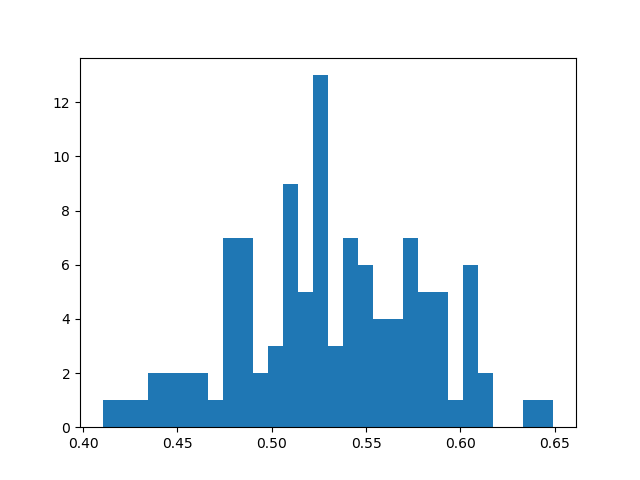

In [888]:
# all results prom above cross-validation on histogram
plt.figure()
plt.hist(results, bins=30)
plt.show()

In [889]:
# Conclusion: Still better than random results !